# 2026-01-13 Exploring Distance Distribution.ipynb
check how distances are distributed in the datasets we generated

In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Add parent directory to path for imports
sys.path.insert(0, str(Path.cwd().parent))

from refactor_training import npz_to_dataset

# Configure data directory - adjust as needed for your environment
# Uses TERRAIN_OUTPUT_DIR if set, otherwise falls back to common locations
OUTPUT_DIR = Path(os.environ.get('TERRAIN_OUTPUT_DIR', '/data/sam/terrain'))

# For cluster: /vast/projects/aribeiro/alelab/jporras/shortest-paths-nn
# For local: adjust to your data location
if not OUTPUT_DIR.exists():
    # Try alternative locations
    alternatives = [
        Path('/vast/projects/aribeiro/alelab/jporras/shortest-paths-nn'),
        Path.cwd().parent,  # repo root
    ]
    for alt in alternatives:
        if alt.exists():
            OUTPUT_DIR = alt
            break

print(f"Using OUTPUT_DIR: {OUTPUT_DIR}")

/home/jporras/miniconda3/envs/shortest-paths-nn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Currently logged in as: jotaporras (alelab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using OUTPUT_DIR: /home/jporras/sourcecode/shortest-paths-nn


In [2]:
# Define resolutions to compare
resolutions = ['01', '40']

# Data structure to hold loaded data
data = {}

for res in resolutions:
    # Try generated2 first (smaller fractions), then generated (original)
    train_path = OUTPUT_DIR / 'data' / 'generated2' / f'res{res}_phase1.npz'
    if not train_path.exists():
        train_path = OUTPUT_DIR / 'data' / 'generated' / f'res{res}_phase1.npz'
    
    test_path = OUTPUT_DIR / 'data' / 'generated2' / 'full_test-001.npz'
    if not test_path.exists():
        test_path = OUTPUT_DIR / 'data' / 'generated' / 'full_test-001.npz'
    
    print(f"\n=== Resolution {res} ===")
    print(f"Train path: {train_path}")
    print(f"Test path: {test_path}")
    
    # Load train data
    if train_path.exists():
        train_data = np.load(train_path, allow_pickle=True)
        train_dataset, train_node_features, train_edge_index = npz_to_dataset(train_data)
        train_lengths = train_data['lengths']
        print(f"Train samples: {len(train_lengths)}, Nodes: {len(train_node_features)}")
        print(f"Train lengths - min: {train_lengths.min():.4f}, max: {train_lengths.max():.4f}, mean: {train_lengths.mean():.4f}")
    else:
        print(f"WARNING: Train file not found: {train_path}")
        train_lengths = None
    
    # Load test data
    if test_path.exists():
        test_data = np.load(test_path, allow_pickle=True)
        test_dataset, test_node_features, test_edge_index = npz_to_dataset(test_data)
        test_lengths = test_data['lengths']
        print(f"Test samples: {len(test_lengths)}, Nodes: {len(test_node_features)}")
        print(f"Test lengths - min: {test_lengths.min():.4f}, max: {test_lengths.max():.4f}, mean: {test_lengths.mean():.4f}")
    else:
        print(f"WARNING: Test file not found: {test_path}")
        test_lengths = None
    
    data[res] = {
        'train_lengths': train_lengths,
        'test_lengths': test_lengths,
    }


=== Resolution 01 ===
Train path: /home/jporras/sourcecode/shortest-paths-nn/data/generated2/res01_phase1.npz
Test path: /home/jporras/sourcecode/shortest-paths-nn/data/generated2/full_test-001.npz
Train samples: 50000, Nodes: 4000000
Train lengths - min: 0.1301, max: 28.7205, mean: 11.1621
Test samples: 200000000, Nodes: 4000000
Test lengths - min: 0.0000, max: 28.5423, mean: 11.2961

=== Resolution 40 ===
Train path: /home/jporras/sourcecode/shortest-paths-nn/data/generated2/res40_phase1.npz
Test path: /home/jporras/sourcecode/shortest-paths-nn/data/generated2/full_test-001.npz
Train samples: 50000, Nodes: 2500
Train lengths - min: 0.0000, max: 27.6070, mean: 7.9426
Test samples: 200000000, Nodes: 4000000
Test lengths - min: 0.0000, max: 28.5423, mean: 11.2961


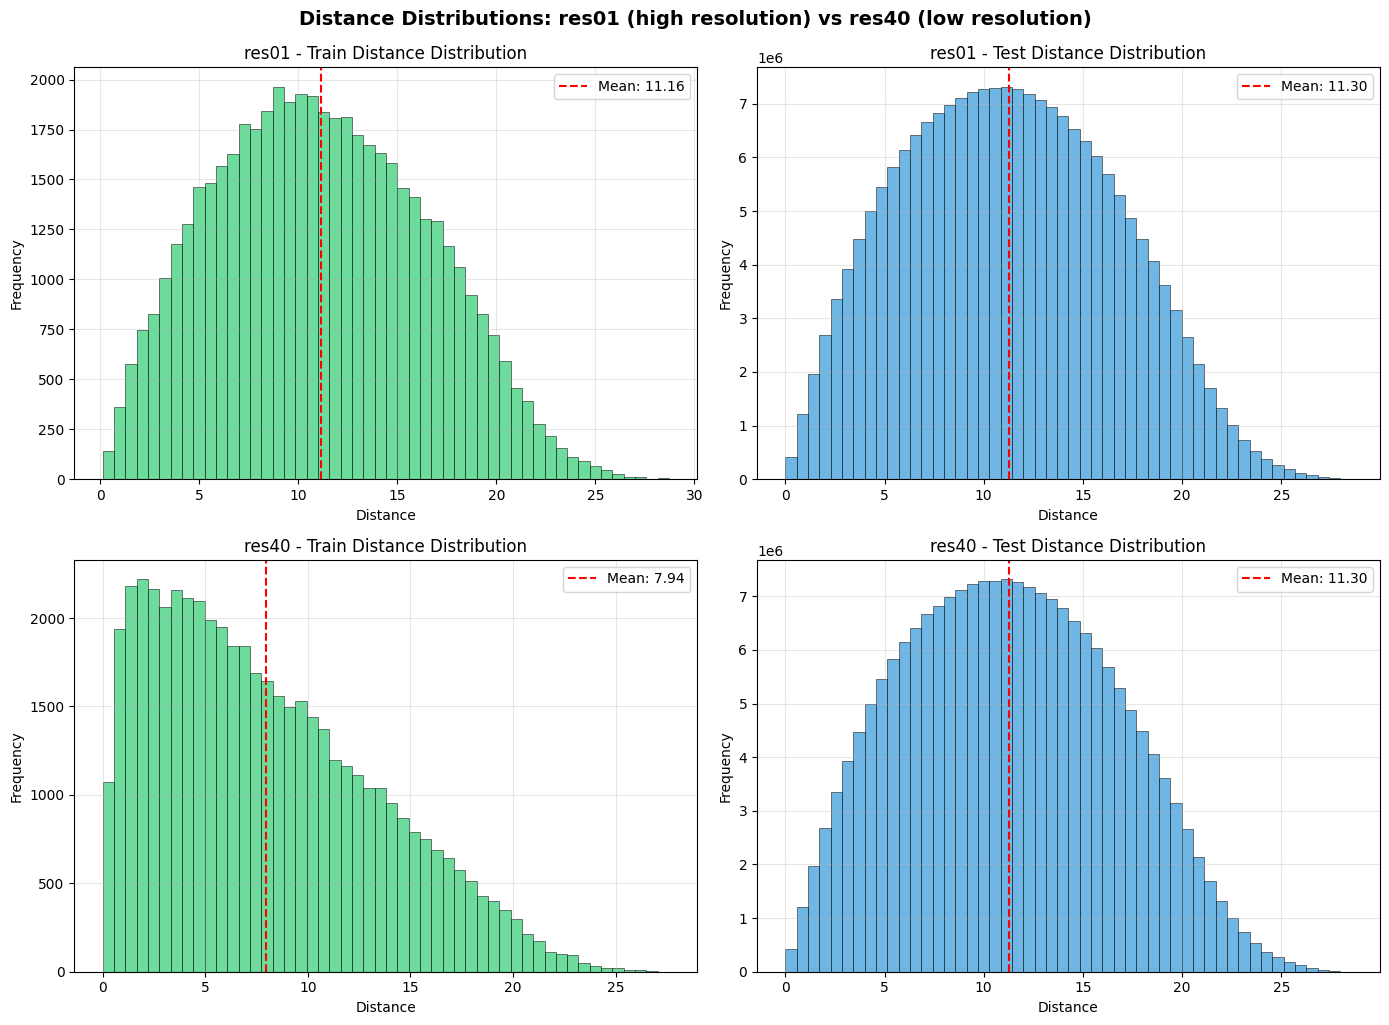

In [3]:
# Plot distance distributions for res01 and res40
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = {'train': '#2ecc71', 'test': '#3498db'}
bins = 50

for i, res in enumerate(resolutions):
    res_data = data[res]
    
    # Train distribution
    ax_train = axes[i, 0]
    if res_data['train_lengths'] is not None:
        ax_train.hist(res_data['train_lengths'], bins=bins, color=colors['train'], 
                      alpha=0.7, edgecolor='black', linewidth=0.5)
        ax_train.axvline(res_data['train_lengths'].mean(), color='red', linestyle='--', 
                         label=f"Mean: {res_data['train_lengths'].mean():.2f}")
        ax_train.legend()
    ax_train.set_xlabel('Distance')
    ax_train.set_ylabel('Frequency')
    ax_train.set_title(f'res{res} - Train Distance Distribution')
    ax_train.grid(True, alpha=0.3)
    
    # Test distribution
    ax_test = axes[i, 1]
    if res_data['test_lengths'] is not None:
        ax_test.hist(res_data['test_lengths'], bins=bins, color=colors['test'], 
                     alpha=0.7, edgecolor='black', linewidth=0.5)
        ax_test.axvline(res_data['test_lengths'].mean(), color='red', linestyle='--', 
                        label=f"Mean: {res_data['test_lengths'].mean():.2f}")
        ax_test.legend()
    ax_test.set_xlabel('Distance')
    ax_test.set_ylabel('Frequency')
    ax_test.set_title(f'res{res} - Test Distance Distribution')
    ax_test.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Distance Distributions: res01 (high resolution) vs res40 (low resolution)', 
             y=1.02, fontsize=14, fontweight='bold')
plt.show()

In [ ]:
# Overlay comparison: Train vs Test for each resolution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, res in enumerate(resolutions):
    ax = axes[i]
    res_data = data[res]
    
    if res_data['train_lengths'] is not None:
        ax.hist(res_data['train_lengths'], bins=bins, color=colors['train'], 
                alpha=0.6, label=f'Train (n={len(res_data["train_lengths"])})', 
                density=True, edgecolor='black', linewidth=0.3)
    
    if res_data['test_lengths'] is not None:
        ax.hist(res_data['test_lengths'], bins=bins, color=colors['test'], 
                alpha=0.6, label=f'Test (n={len(res_data["test_lengths"])})', 
                density=True, edgecolor='black', linewidth=0.3)
    
    ax.set_xlabel('Distance')
    ax.set_ylabel('Density')
    ax.set_title(f'res{res} - Train vs Test (Normalized)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

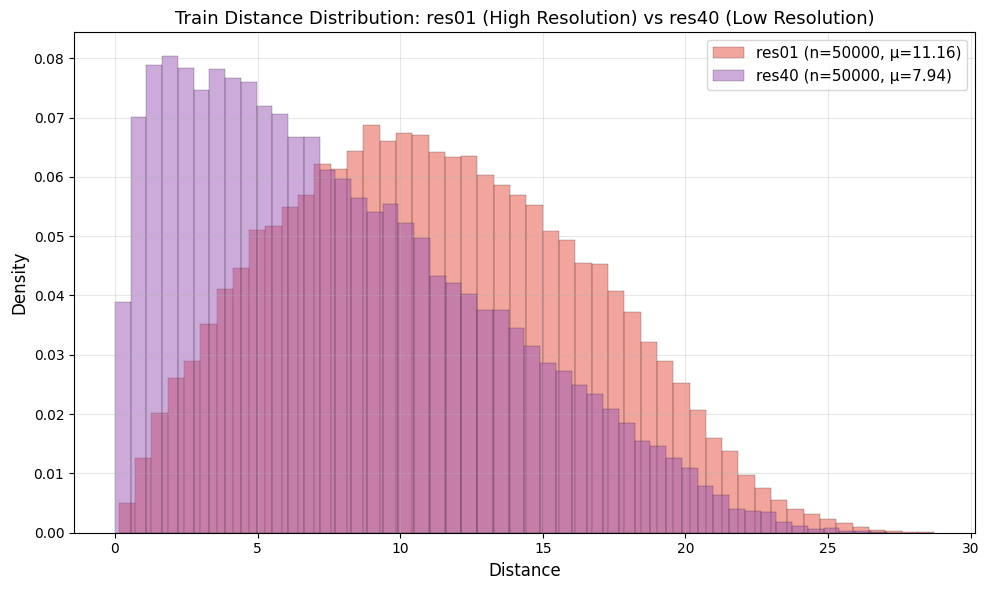

In [4]:
# Direct comparison: res01 vs res40 (Train only)
fig, ax = plt.subplots(figsize=(10, 6))

colors_res = {'01': '#e74c3c', '40': '#9b59b6'}

for res in resolutions:
    res_data = data[res]
    if res_data['train_lengths'] is not None:
        ax.hist(res_data['train_lengths'], bins=bins, color=colors_res[res], 
                alpha=0.5, label=f'res{res} (n={len(res_data["train_lengths"])}, μ={res_data["train_lengths"].mean():.2f})', 
                density=True, edgecolor='black', linewidth=0.3)

ax.set_xlabel('Distance', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Train Distance Distribution: res01 (High Resolution) vs res40 (Low Resolution)', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
# Summary statistics table
import pandas as pd

stats_rows = []
for res in resolutions:
    res_data = data[res]
    for split, key in [('Train', 'train_lengths'), ('Test', 'test_lengths')]:
        lengths = res_data[key]
        if lengths is not None:
            stats_rows.append({
                'Resolution': f'res{res}',
                'Split': split,
                'Count': len(lengths),
                'Min': f'{lengths.min():.4f}',
                'Max': f'{lengths.max():.4f}',
                'Mean': f'{lengths.mean():.4f}',
                'Std': f'{lengths.std():.4f}',
                'Median': f'{np.median(lengths):.4f}',
            })

stats_df = pd.DataFrame(stats_rows)
print("Distance Distribution Summary Statistics")
print("=" * 80)
stats_df

Distance Distribution Summary Statistics


,Resolution,Split,Count,Min,Max,Mean,Std,Median
0,res01,Train,50000,0.1301,28.7205,11.1621,5.2967,10.9058
1,res01,Test,200000000,0.0000,28.5423,11.2961,5.3358,11.1398
2,res40,Train,50000,0.0000,27.6070,7.9426,5.3508,6.9942
3,res40,Test,200000000,0.0000,28.5423,11.2961,5.3358,11.1398
